In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import re
from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.corpus import stopwords
from os import listdir
from os.path import isfile, join
from bs4 import BeautifulSoup
from itertools import chain
from collections import Counter
%matplotlib ipympl
%matplotlib inline

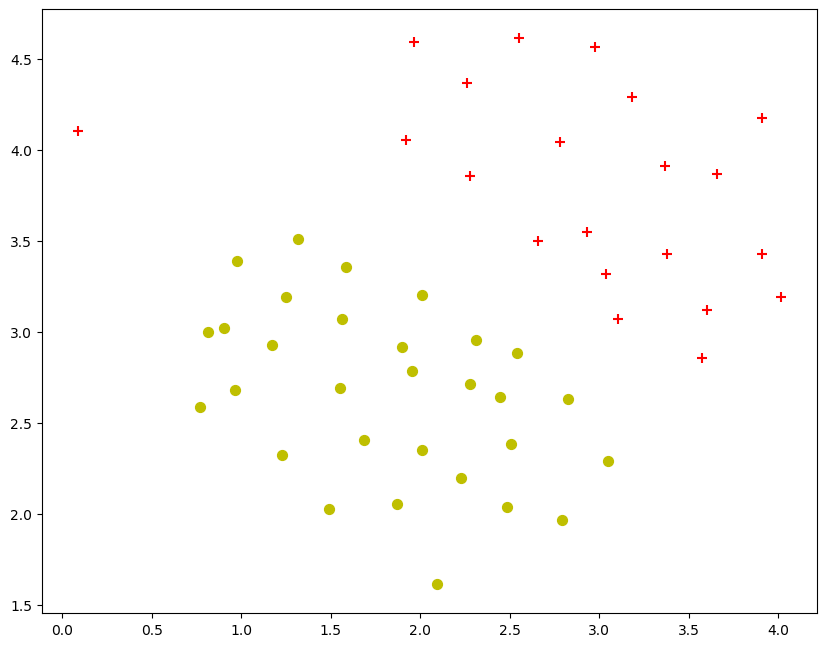

In [6]:
mat = loadmat("data/Lab5/ex5data1.mat")
X_1 = mat["X"]
y_1 = mat["y"]
positive_label=y_1==1
negative_label=y_1==0
plt.figure(figsize=(10, 8), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(X_1[positive_label[:, 0],0],X_1[positive_label[:, 0],1],c="r",marker="+",s=50)
plt.scatter(X_1[negative_label[:, 0],0],X_1[negative_label[:, 0],1],c="y",marker="o",s=50)

In [4]:
classifier_c1 = SVC(kernel="linear", C=1)
classifier_c1.fit(X_1,np.ravel(y_1))

classifier_c100 = SVC(kernel="linear", C=100)
classifier_c100.fit(X_1,np.ravel(y_1))

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

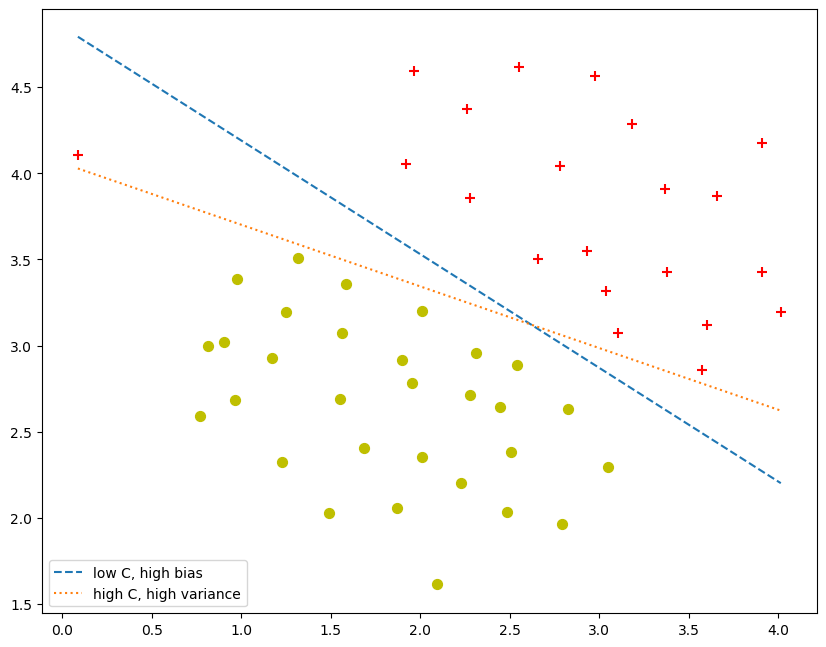

In [7]:
x1s = np.linspace(min(X_1[:, 0]), max(X_1[:, 0]), 20)
x2s_c1 = (-classifier_c1.intercept_ - classifier_c1.coef_[0][0]*x1s)/classifier_c1.coef_[0][1]
x2s_c100 = (-classifier_c100.intercept_ - classifier_c100.coef_[0][0]*x1s)/classifier_c100.coef_[0][1]

fig, ax = plt.subplots(figsize=(10, 8), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(X_1[positive_label[:, 0],0],X_1[positive_label[:, 0],1],c="r",marker="+",s=50)
plt.scatter(X_1[negative_label[:, 0],0],X_1[negative_label[:, 0],1],c="y",marker="o",s=50)
ax.plot(x1s, x2s_c1, linestyle="--", label="low C, high bias")
ax.plot(x1s, x2s_c100, linestyle=":", label="high C, high variance")
ax.legend(loc="lower left")

In [45]:
def gausian_similarity(X, Y, sigma):
    return np.exp(-np.sum(np.square(X-Y), axis=1) / (2.0 * sigma ** 2))

def get_gausian_gram_matrix(X, Y, sigma=0.1):
    n_items, n_features=X.shape[0], Y.shape[0]
    transformed_items=np.zeros((n_items, n_features))
    for item1_idx, item1 in enumerate(X):
        transformed_items[item1_idx, :]=gausian_similarity(item1, Y, sigma)
    return transformed_items

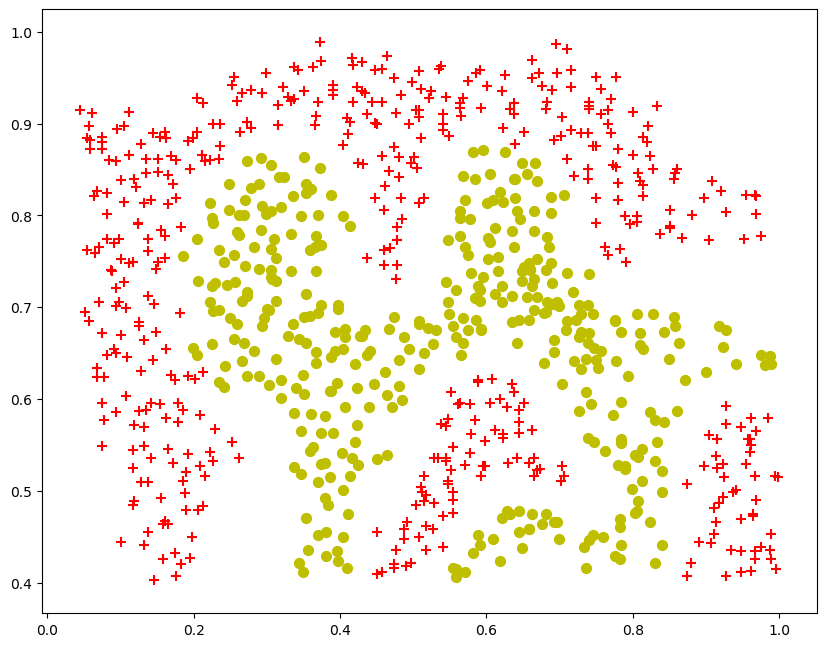

In [9]:
mat = loadmat("data/Lab5/ex5data2.mat")
X_2 = mat["X"]
y_2 = mat["y"]
positive_label=y_2==1
negative_label=y_2==0
plt.figure(figsize=(10, 8), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(X_2[positive_label[:, 0],0],X_2[positive_label[:, 0],1],c="r",marker="+",s=50)
plt.scatter(X_2[negative_label[:, 0],0],X_2[negative_label[:, 0],1],c="y",marker="o",s=50)

In [51]:
X_2_gaus_transfomed=get_gausian_gram_matrix(X_2, X_2)
svm_gauss_c1 = SVC(kernel="precomputed", C=1)
svm_gauss_c1.fit(X_2_gaus_transfomed, y_2.flatten())
svm_gauss_c100 = SVC(kernel="precomputed", C=100)       
svm_gauss_c100.fit(X_2_gaus_transfomed, y_2.flatten())

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='precomputed', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [56]:
x1s = np.linspace(min(X_2[:, 0]), max(X_2[:, 0]), 1000)
x2s = np.linspace(min(X_2[:, 1]), max(X_2[:, 1]), 1000)
points = np.array([[x1, x2] for x1 in x1s for x2 in x2s])
points_transformed=get_gausian_gram_matrix(points, X_2)

dist_c1 = svm_gauss_c1.decision_function(points_transformed)
bounds_c1 = np.array([pt.tolist() for pt, dist in zip(points, dist_c1) if abs(dist)<0.05])

dist_c100 = svm_gauss_c100.decision_function(points_transformed)
bounds_c100 = np.array([pt.tolist() for pt, dist in zip(points, dist_c100) if abs(dist)<0.05])

Text(0.5, 1.0, 'Overfit SVM with Gaussian Kernel')

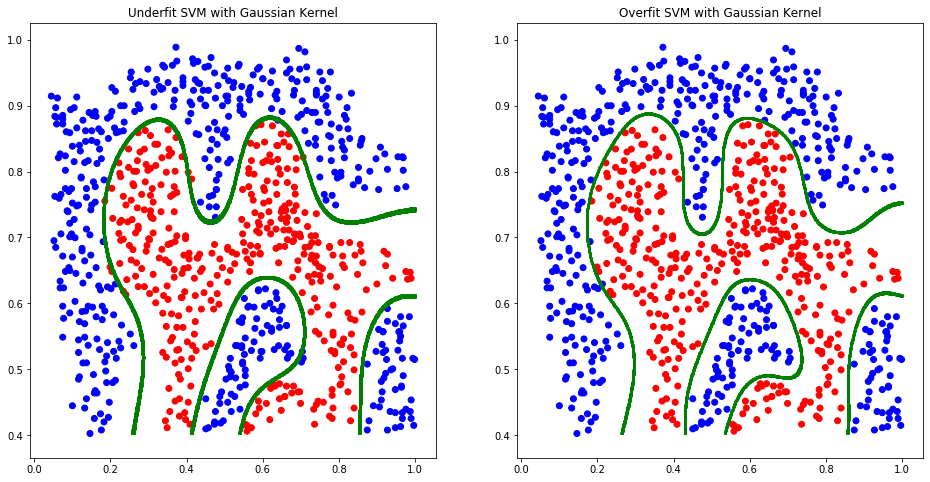

In [59]:
fig, [ax1, ax2] = plt.subplots(figsize=[16, 8], nrows=1, ncols=2)

ax1.scatter(X_2[:, 0], X_2[:, 1], color=["r" if y == 0 else "b" for y in y_2], label="data")
ax1.scatter(bounds_c1[:, 0], bounds_c1[:, 1], color="g", s=3, label="decision boundary")
ax1.set_title("Underfit SVM with Gaussian Kernel")

ax2.scatter(X_2[:, 0], X_2[:, 1], color=["r" if y == 0 else "b" for y in y_2], label="data")
ax2.scatter(bounds_c100[:, 0], bounds_c100[:, 1], color="g", s=3, label="decision boundary")
ax2.set_title("Overfit SVM with Gaussian Kernel")

In [60]:
mat = loadmat("data/Lab5/ex5data3.mat")
X_3 = mat["X"]
y_3 = mat["y"]
X_3_val = mat["Xval"]
y_3_val = mat["yval"]

In [61]:
best_score=0
best_values=(0, 0)
for C_value in np.logspace(-1, 3, 100):
    for gamma in np.linspace(0.0001, 10, 100):
        svm = SVC(C=C_value, kernel='rbf', gamma=gamma)
        svm.fit(X_3, y_3.flatten())
        score = svm.score(X_3_val,y_3_val.flatten())
        if score > best_score:
            best_score = score
            best_pair = (C_value, gamma)
print(f"Best svm params: C={best_pair[0]}, sigma={best_pair[1]}")

Best svm params: C=0.36783797718286343, sigma=9.292936363636363


In [62]:
best_C, best_gamma=best_pair
best_svm=SVC(C=best_C, kernel='rbf', gamma=best_gamma)
best_svm.fit(X_3, y_3.flatten())

x1s = np.linspace(min(X_3[:, 0]), max(X_3[:, 0]), 600)
x2s = np.linspace(min(X_3[:, 1]), max(X_3[:, 1]), 600)
points = np.array([[x1, x2] for x1 in x1s for x2 in x2s])

dist_ex3 = best_svm.decision_function(points)
bounds_ex3 = np.array([pt.tolist() for pt, dist in zip(points, dist_ex3) if abs(dist)<0.05])

Text(0.5, 1.0, 'Best SVM with Gaussian Kernel')

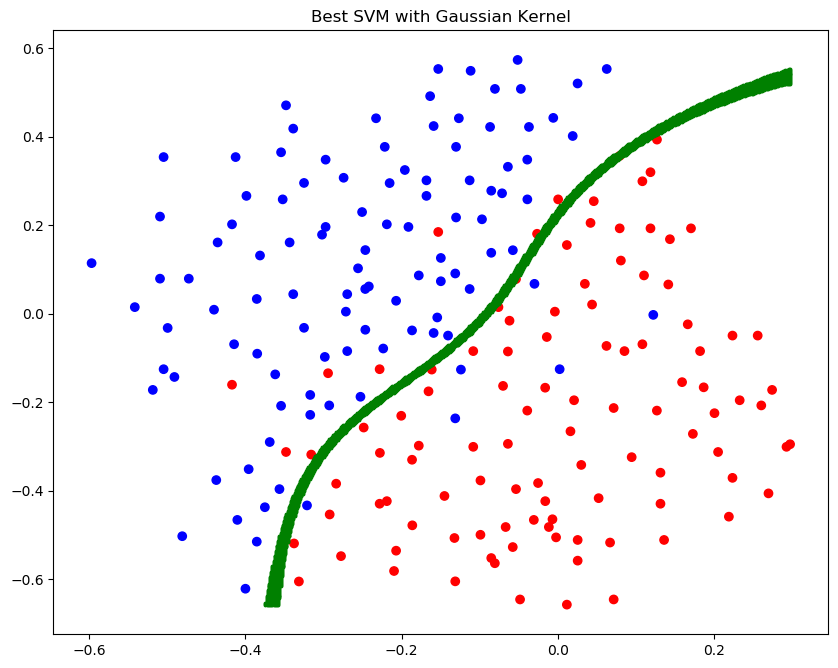

In [64]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)

ax.scatter(X_3[:, 0], X_3[:, 1], color=["r" if y == 0 else "b" for y in y_3], label="data")
ax.scatter(bounds_ex3[:, 0], bounds_ex3[:, 1], color="g", s=3, label="decision boundary")
ax.set_title("Best SVM with Gaussian Kernel")

In [65]:
data = loadmat('data/Lab5/spamTrain.mat')
data_test = loadmat('data/Lab5/spamTest.mat')
X_spam = data['X']
y_spam = data['y'].flatten()
X_spam_test = data_test['Xtest']
y_spam_test = data_test['ytest'].flatten()

In [66]:
spam_classifier=SVC(C=0.1, kernel='linear')
best_score=0
best_values=(0, 0)
for C_value in np.logspace(-1, 3, 20):
    print(f"Process c={C_value}")
    for gamma in np.linspace(0.0001, 10, 20):
        svm = SVC(C=C_value, kernel='linear', gamma=gamma)
        svm.fit(X_spam, y_spam)
        score = svm.score(X_spam_test,y_spam_test)
        if score > best_score:
            best_score = score
            best_pair = (C_value, gamma)
print(f"Best svm params: C={best_pair[0]}, sigma={best_pair[1]}")

Process c=0.1
Process c=0.16237767391887217
Process c=0.26366508987303583
Process c=0.42813323987193935
Process c=0.6951927961775606
Process c=1.1288378916846888
Process c=1.8329807108324356
Process c=2.9763514416313175
Process c=4.832930238571752
Process c=7.847599703514611
Process c=12.742749857031335
Process c=20.6913808111479
Process c=33.59818286283781
Process c=54.555947811685144
Process c=88.58667904100822
Process c=143.8449888287663
Process c=233.57214690901213
Process c=379.2690190732246
Process c=615.8482110660261
Process c=1000.0
Best svm params: C=0.1, sigma=0.0001


In [67]:
def preprocess_email(body):
    soup = BeautifulSoup(body, 'html.parser')
    body = soup.get_text()
    nhtml = len(soup.find_all())
    nlinks = len(soup.find_all("a"))
    body = body + nhtml*" htmltag " + nlinks*" linktag "
    body = body.lower()
    regx = re.compile('<[^<>]+>|\n')
    body = regx.sub(repl=' ', string=body)
    regx = re.compile(r"(http|https)://[^\s]*")
    body, nhttps = regx.subn(repl=" httpaddr ", string=body)
    regx = re.compile(r"\b[^\s]+@[^\s]+[.][^\s]+\b")
    body, nemails = regx.subn(repl=" emailaddr ", string=body)
    regx = re.compile(r"\b[\d.]+\b")
    body = regx.sub(repl=" number ", string=body)
    regx = re.compile(r"[$]")
    body = regx.sub(repl=" dollar ", string=body)
    regx = re.compile(r"[!]")
    body = regx.sub(repl=" exclammark ", string=body)
    regx = re.compile(r"[?]")
    body = regx.sub(repl=" questmark ", string=body)
    regx = re.compile(r"([^\w\s]+)|([_-]+)")  
    body = regx.sub(repl=" ", string=body)
    regx = re.compile(r"\n")
    body = regx.sub(repl=" newline ", string=body)
    regx = re.compile(r"\n\n")
    body = regx.sub(repl=" blankline ", string=body)
    regx = re.compile(r"\s+")
    body = regx.sub(repl=" ", string=body)
    body = body.strip(" ")
    bodywords = body.split(" ")
    keepwords = [word for word in bodywords if word not in stopwords.words('english')]
    stemmer = SnowballStemmer("english")
    stemwords = [stemmer.stem(wd) for wd in keepwords]
    body = " ".join(stemwords)
    return body

In [68]:
best_C, best_gamma=best_pair
best_svm=SVC(C=best_C, kernel='linear', gamma=best_gamma)
best_svm.fit(X_spam, y_spam)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [69]:
words_dictionary = {}
with open('data/Lab5/vocab.txt') as f:
    for line in f:
        code, word = line.split()
        words_dictionary[int(code)]=word
code_weight={
    code: weight for code, weight in enumerate(best_svm.coef_[0])
}
print("Top 10 spam markers")
for code, weight in sorted(code_weight.items(), key=lambda item: item[1], reverse=True)[:10]:
    print(words_dictionary[code])

Top 10 spam markers
otherwis
clearli
remot
gt
visa
base
doesn
wife
previous
player


In [70]:
def substitute_words(body, words_dictionary):
    body_of_codes=[]
    word_code_map={
        word: code for code, word in words_dictionary.items()
    }
    for word in body.split(" "):
        body_of_codes.append(word_code_map.get(word, -1))
    return body_of_codes
        

In [73]:
def convert_to_features(body_of_codes, words_dictionary):
    features=np.zeros((1, len(words_dictionary)))
    body_of_codes_set=set(body_of_codes)
    for code in words_dictionary:
        if code in body_of_codes_set:
            features[0, code-1]=1
    return features

In [74]:
def test_spam_predictor(svm_spam_model, email_files, words_dictionary):
    for email_file_name in email_files:
        with open(f"data/Lab5/{email_file_name}") as email_file:
            body=email_file.read()
            preprocessed_body=preprocess_email(body)
            body_of_codes=substitute_words(preprocessed_body, words_dictionary)
            features=convert_to_features(body_of_codes, words_dictionary)
            if svm_spam_model.predict(features)==0:
                print(f"Email {email_file_name} isn't spam mail")
            else:
                print(f"Email {email_file_name} is spam mail")

In [75]:
email_files=["emailSample1.txt", "emailSample2.txt", "spamSample1.txt", "spamSample2.txt"]
test_spam_predictor(best_svm, email_files, words_dictionary)

Email emailSample1.txt is spam mail
Email emailSample2.txt isn't spam mail
Email spamSample1.txt is spam mail
Email spamSample2.txt is spam mail


In [77]:
spampath = "data/Lab5/spam"
spampath_2 = "data/Lab5/spam_2"
spamfiles = [join(spampath, fname) for fname in listdir(spampath)]+[join(spampath_2, fname) for fname in listdir(spampath_2)]

hampath = "data/Lab5/easy_ham"
hampath_2 = "data/Lab5/easy_ham_2"
hamfiles = [join(hampath, fname) for fname in listdir(hampath)]+[join(hampath_2, fname) for fname in listdir(hampath_2)]

In [83]:
def get_body_wo_header(file_path):
    with open(file_path, "r") as email_file:
        lines = email_file.readlines()
        if "\n" in lines:
            idx = lines.index("\n") 
            lines=lines[idx:]
        return "".join(lines)
            
emails_raw =  ["email"]*(len(hamfiles) + len(spamfiles))
emails_processed =  ["email"]*(len(hamfiles) + len(spamfiles))
y = np.concatenate((np.zeros(len(hamfiles)), np.ones(len(spamfiles))))

for idx, file_path in enumerate(chain(hamfiles, spamfiles)):
    try: 
        body = get_body_wo_header(file_path)
        processed_email = preprocess_email(body)
        emails_raw[idx] = body
        emails_processed[idx] = processed_email
    except Exception as e: 
        print(e)
        print(f"Couldn't parse file {file_path}")

'charmap' codec can't decode byte 0x98 in position 2773: character maps to <undefined>
Couldn't parse file data/Lab5/spam\00263.13fc73e09ae15e0023bdb13d0a010f2d
'charmap' codec can't decode byte 0x98 in position 2679: character maps to <undefined>
Couldn't parse file data/Lab5/spam\00320.20dcbb5b047b8e2f212ee78267ee27ad
'charmap' codec can't decode byte 0x98 in position 2858: character maps to <undefined>
Couldn't parse file data/Lab5/spam\00323.9e36bf05304c99f2133a4c03c49533a9
'charmap' codec can't decode byte 0x98 in position 2904: character maps to <undefined>
Couldn't parse file data/Lab5/spam\00324.6f320a8c6b5f8e4bc47d475b3d4e86ef
'charmap' codec can't decode byte 0x98 in position 1706: character maps to <undefined>
Couldn't parse file data/Lab5/spam\00500.85b72f09f6778a085dc8b6821965a76f


In [91]:
word_list = [word for word in chain.from_iterable(email.split(" ") for email in emails_processed)]
wourd_counter = Counter(word_list)
word_list = [word for word in wourd_counter if wourd_counter[word] > 100]
word_dictionary={
    idx: word for idx, word in enumerate(word_list)
}

In [92]:
def vectorize_body(body, word_dictionary):
    vectorized_body=np.zeros(len(word_dictionary))
    body_word_counter=Counter(body.split(" "))
    for code, word in word_dictionary.items():
        vectorized_body[code]=body_word_counter.get(word, 0)
    return vectorized_body

In [93]:
def convert_to_tf_idf(vectorized_bodies, word_dictionary, use_idf=False):
    tf_idf_vec=np.copy(vectorized_bodies)/np.sum(vectorized_bodies,  axis=1)
    if use_idf:
        D=vectorized_bodies.shape[0]
        for code, word in word_dictionary.items():
            occuriances_count=np.sum(vectorized_bodies[:code] != 0)
            idf=np.log(D/occuriances_count)
            vectorized_bodies[:, code]=vectorized_bodies[:, code]*idf
    return vectorized_bodies

In [101]:
vectorized_bodies=np.zeros((len(emails_processed), len(word_dictionary)))
for i, email in enumerate(emails_processed):
    body=vectorize_body(email, word_dictionary)
    vectorized_bodies[i, :]=body[:]

In [103]:
svm=SVC(C=2.15, kernel='rbf', gamma= 2.15)
svm.fit(vectorized_bodies, y)
svm.score(vectorized_bodies, y) #on test data

0.9998275862068966